In [282]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

데이터 로드 (q: 15분 단위, h: 1시간 단위)

In [283]:
generation_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_generation.csv")
generation_q['Time'] = pd.to_datetime(generation_q['Time'], format='%Y-%m-%d %H:%M')

In [284]:
generation_q['Hour'] = generation_q['Time'].dt.floor('H')    # 시간으로 그룹화
generation_h = generation_q.groupby('Hour').sum(numeric_only=True)  # 각 시간대별로 합계 계산

In [285]:
demand_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_demand.csv")
demand_q['Time'] = pd.to_datetime(demand_q['Time'], format='%Y-%m-%d %H:%M')

In [286]:
demand_q['Hour'] = demand_q['Time'].dt.floor('H')    # 시간으로 그룹화
demand_h = demand_q.groupby('Hour').sum(numeric_only=True)  # 각 시간대별로 합계 계산

In [287]:
price_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_price.csv")
price_q['Time'] = pd.to_datetime(price_q['Time'], format='%Y-%m-%d %H:%M')

set 설정

In [288]:
I = list(range(len(generation_q.columns) - 2))
T = list(generation_q['Time'].dt.hour.unique())

In [289]:
S = list(range(10))
prob = {s: 1 / len(S) for s in S}

Generation (randomized) 

In [290]:
generation_avg = {
    (i, t): generation_h[generation_h.index.hour == t].mean()[i] for i in I for t in T
}   

In [291]:
np.random.seed(7)
generation_r = {
    (i, t, s): max(0, generation_avg[(i, t)] + np.random.normal(0, 1)) for i in I for t in T for s in S
}

In [292]:
generation_r

{(0, 0, 0): 1.6906139229784383,
 (0, 0, 1): 0,
 (0, 0, 2): 0.03290838285666659,
 (0, 0, 3): 0.40760450217459004,
 (0, 0, 4): 0,
 (0, 0, 5): 0.002153792084030322,
 (0, 0, 6): 0,
 (0, 0, 7): 0,
 (0, 0, 8): 1.0177462248415754,
 (0, 0, 9): 0.6005867350976316,
 (0, 1, 0): 0,
 (0, 1, 1): 0,
 (0, 1, 2): 0.5055593739255188,
 (0, 1, 3): 0,
 (0, 1, 4): 0,
 (0, 1, 5): 0,
 (0, 1, 6): 0.554840311620655,
 (0, 1, 7): 0.12414090501580556,
 (0, 1, 8): 0.2747199234887307,
 (0, 1, 9): 0,
 (0, 2, 0): 1.6515728843262016,
 (0, 2, 1): 0.15520872859608406,
 (0, 2, 2): 0,
 (0, 2, 3): 2.0299454139008377,
 (0, 2, 4): 0,
 (0, 2, 5): 0,
 (0, 2, 6): 0,
 (0, 2, 7): 0,
 (0, 2, 8): 1.0502697424829808,
 (0, 2, 9): 0,
 (0, 3, 0): 0,
 (0, 3, 1): 1.0741674831809749,
 (0, 3, 2): 0,
 (0, 3, 3): 0.5371267079315705,
 (0, 3, 4): 0,
 (0, 3, 5): 0,
 (0, 3, 6): 0,
 (0, 3, 7): 1.4636729788190035,
 (0, 3, 8): 1.7678582295348133,
 (0, 3, 9): 0,
 (0, 4, 0): 0.8467680366640836,
 (0, 4, 1): 0,
 (0, 4, 2): 0.5740966818485298,
 (0, 4, 3)

Demand (randomized)

In [293]:
demand_avg = {
    (i, t): demand_h[demand_h.index.hour == t].mean()[i] for i in I for t in T
}

In [294]:
np.random.seed(17)
demand_r = {
    (i, t, s): max(0, demand_avg[(i, t)] + np.random.normal(0, 1)) for i in I for t in T for s in S
}  

Residual = generation - demand

In [295]:
residual = {(i, t, s): generation_r[(i, t, s)] - demand_r[(i, t, s)] for i in I for t in T for s in S}

In [296]:
residual

{(0, 0, 0): -3.3983716960264374,
 (0, 0, 1): -2.9580916501770522,
 (0, 0, 2): -5.403712457453247,
 (0, 0, 3): -5.550426516381058,
 (0, 0, 4): -5.8499101972114405,
 (0, 0, 5): -6.697204866681135,
 (0, 0, 6): -4.7010214388547915,
 (0, 0, 7): -4.450618390584509,
 (0, 0, 8): -3.943648549187226,
 (0, 0, 9): -3.7743498413712935,
 (0, 1, 0): -6.721977819421712,
 (0, 1, 1): -5.703031072538723,
 (0, 1, 2): -2.226349108686721,
 (0, 1, 3): -4.412671481065427,
 (0, 1, 4): -5.090560435772743,
 (0, 1, 5): -2.77543853480677,
 (0, 1, 6): -5.310757046174783,
 (0, 1, 7): -3.9531318698252096,
 (0, 1, 8): -3.1837709976991526,
 (0, 1, 9): -4.300693380177317,
 (0, 2, 0): -2.444059777932539,
 (0, 2, 1): -5.953987329724107,
 (0, 2, 2): -5.56926074135531,
 (0, 2, 3): -2.601334947737408,
 (0, 2, 4): -4.2715668839349625,
 (0, 2, 5): -5.209194724184554,
 (0, 2, 6): -3.865366727457393,
 (0, 2, 7): -5.237917819332208,
 (0, 2, 8): -3.2724341877231202,
 (0, 2, 9): -5.427822958263152,
 (0, 3, 0): -6.825341946974102,
 

In [297]:
R = {
    (i, t, s): max(0, residual[(i, t, s)])
    for i in I for t in T for s in S
}

In [298]:
R[0,12,9]

7.228387142138521

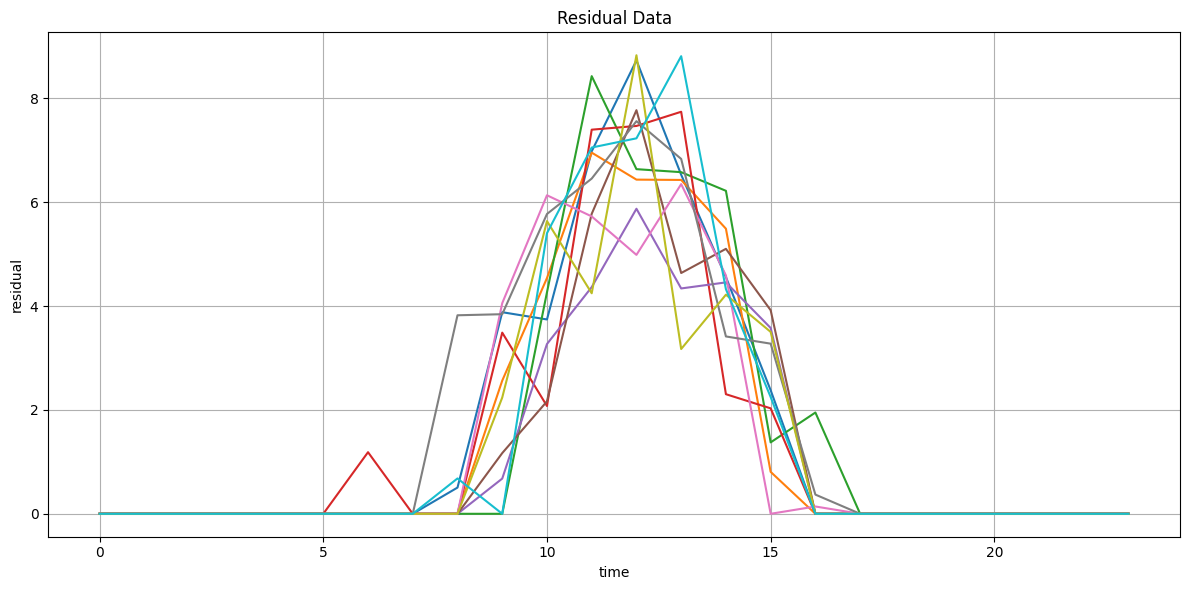

In [299]:
plt.figure(figsize=(12, 6))

for i in I[:1]:
    for s in S:
        plt.plot([t for t in T], [R[i, t, s] for t in T])

plt.title('Residual Data')
plt.xlabel('time')
plt.ylabel('residual')
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()

Price 설정

In [300]:
unique_days = generation_q['Time'].dt.normalize().unique()
days = len(unique_days)
S = list(range(min(len(S), days)))

In [301]:
price_q['Hour'] = price_q['Time'].dt.floor('H')    # 시간으로 그룹화
price_h = price_q.groupby('Hour').mean(numeric_only=True)  # 각 시간대별로 평균 계산

price = price_h.iloc[:len(S)*len(T)]

In [302]:
price

,Price
Hour,
2018-01-01 00:00:00,29.3600
2018-01-01 01:00:00,27.5250
2018-01-01 02:00:00,27.2375
2018-01-01 03:00:00,24.8750
2018-01-01 04:00:00,23.2650
...,...
2018-01-10 19:00:00,12.7725
2018-01-10 20:00:00,12.3750
2018-01-10 21:00:00,12.7350


In [303]:
# 전일 시장 가격 (Day-ahead) 및 실시간 시장 가격 (Real-time)
P_DA = {t: sum(price['Price'].iloc[t + s * len(T)] for s in S) / len(S) * 1.2 for t in T}
P_RT = {(t, s): price['Price'].iloc[t + s * len(T)] for t in T for s in S}

# 패널티 비용 계산
P_PN = {t: sum(price['Price'].iloc[t + s * len(T)] for s in S) / len(S) * 2.3 for t in T}

In [304]:
# P_DA
# P_RT
# P_PN

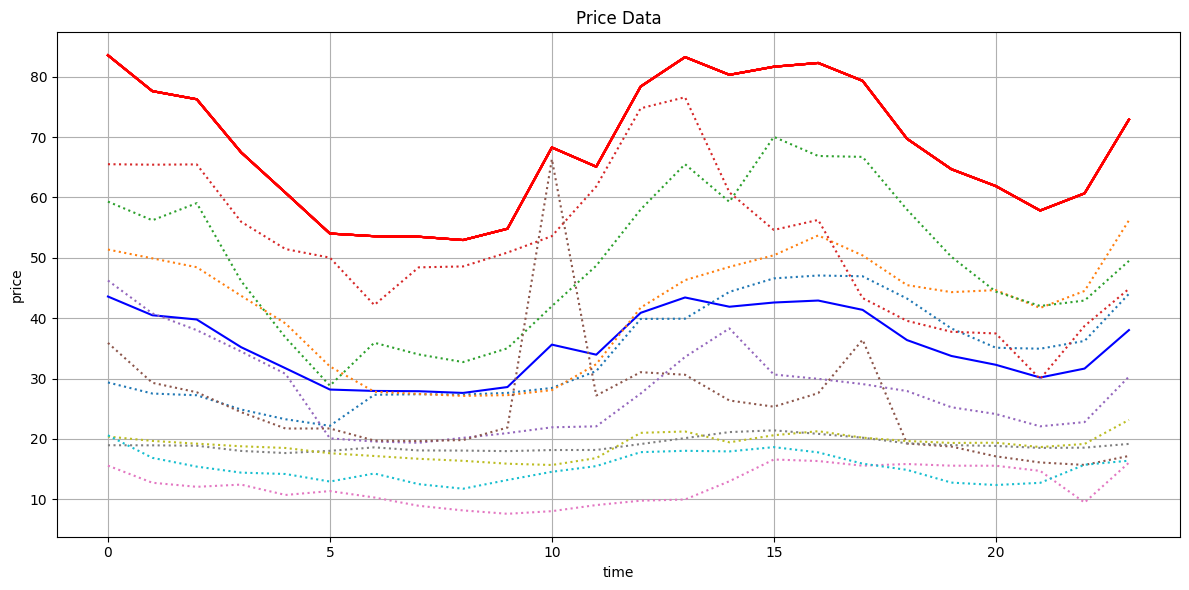

In [305]:
plt.figure(figsize=(12, 6))
plt.plot([t for t in T], [P_DA[t] for t in T], 'b-', label='DA price')

for s in S:
    plt.plot([t for t in T], [P_RT[t, s] for t in T], ':', label=f'RT price (s={s})')
    plt.plot([t for t in T], [P_PN[t] for t in T], 'r-', label=f'Penalty price (s={s})')

plt.title('Price Data')
plt.xlabel('time')
plt.ylabel('price')
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()

모델 DER with Aggregation (Part: Aggregation)

In [306]:
alpha_values = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/alpha_values1.csv")
# beta_values = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/beta_values1.csv")

In [307]:
alpha_DA = {t: alpha_values.iloc[t] for t in T}
# beta_plus = {(t, s): beta_values.iloc[t + s * len(T)]['beta_plus'] for t in T for s in S}
# beta_minus = {(t, s): beta_values.iloc[t + s * len(T)]['beta_minus'] for t in T for s in S}

In [308]:
x_DA_2 = {(i, t): cp.Variable(pos=True) for i in I for t in T}
y_plus_2 = {(i, t, s): cp.Variable(pos=True) for i in I for t in T for s in S}
y_minus_2 = {(i, t, s): cp.Variable(pos=True) for i in I for t in T for s in S}

In [309]:
# 목적함수 계산
obj_case22 = sum(
    P_DA[t] * x_DA_2[i, t] for i in I for t in T
) + sum(
    prob[s] * (P_RT[t, s] * y_plus_2[i, t, s] - P_PN[t] * y_minus_2[i, t, s])
    for i in I for t in T for s in S
)

In [310]:
# 제약조건 정의
constraints = []

for t in T:
    constraints.append(sum(x_DA_2[i, t] for i in I) == alpha_DA[t])

for i in I:
    for t in T:
        for s in S:
            constraints.append(R[i, t, s] - x_DA_2[i, t] == y_plus_2[i, t, s] - y_minus_2[i, t, s])

# for i in I:
#     for t in T:
#         for s in S:
#             constraints.append(R[i,t,s] >= y_plus_2[i, t, s])

In [311]:
prob_case22 = cp.Problem(cp.Maximize(obj_case22), constraints)

# 풀이 실행
prob_case22.solve(solver='GUROBI')

# 결과 출력
print("최적해:")
print(f"총 이익: {prob_case22.value}")

c:\Users\symply_jina\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


최적해:
총 이익: 12273.314826802973


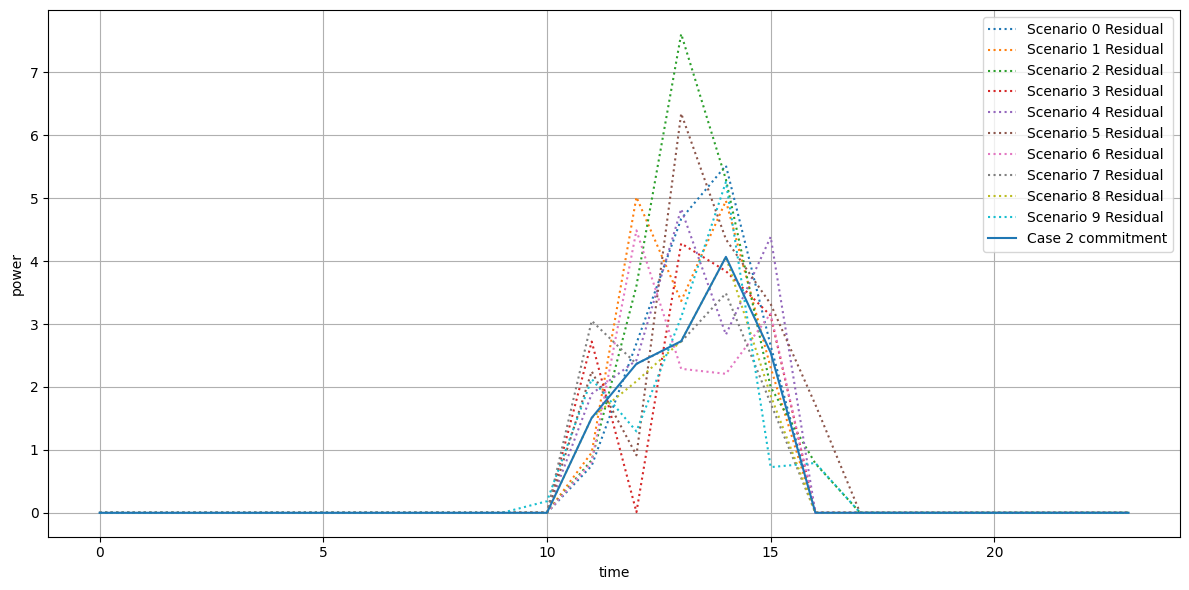

In [312]:
plt.figure(figsize=(12, 6))

i = 5
for s in S:
    plt.plot([t for t in T], [R[i,t,s] for t in T], ':', label=f'Scenario {s} Residual')
plt.plot([t for t in T], [x_DA_2[i,t].value for t in T], '-', label=f'Case 2 commitment')
    # plt.plot([t for t in T], [y_plus_2[i,t,s].value for t in T], 'b:', label=f'Scenario {s} Case 2 y+')

plt.xlabel('time')
plt.ylabel('power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [313]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for i in I:
    for t in T:
        total_da_profit_obj += P_DA[t] * x_DA_2[i,t].value

# Real-time 수익 비교

total_rt_profit_obj = 0
for i in I:
    for t in T:
        for s in S:
            rt_profit_obj = P_RT[t, s] * y_plus_2[i, t, s].value
            total_rt_profit_obj += prob[s] * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for i in I:
    for t in T:
        for s in S:
            penalty_cost_obj = P_PN[t] * y_minus_2[i, t, s].value
            total_penalty_cost_obj += prob[s] * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj

# 결과 출력
print(f"총 Day-ahead 수익 (_obj): {total_da_profit_obj:.2f}")
print(f"총 Real-time 수익 (_obj): {total_rt_profit_obj:.2f}")
print(f"총 Penalty 비용 (_obj): {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")

총 Day-ahead 수익 (_obj): 12876.61
총 Real-time 수익 (_obj): 2694.80
총 Penalty 비용 (_obj): 3298.09
목적 함수 기반 총 이익 (_obj): 12273.31


In [314]:
print("Case 2 최적해:")
print(f"총 이익: {prob_case22.value}")

Case 2 최적해:
총 이익: 12273.314826802973


In [315]:
for i in I: 
    for t in T:
        for s in S:
            if y_plus_2[i, t, s].value > 0 and y_minus_2[i, t, s].value > 0:
                print(f"DER {i}, 시간 {t}, 시나리오 {s}: y+와 y-가 동시에 발생했습니다.")
                break
else:
    print(f"y+와 y-가 동시에 발생하지 않았습니다.")

y+와 y-가 동시에 발생하지 않았습니다.


In [316]:
for t in T:
    print(f"시간 {t}: x = {x_DA_2[5,t].value}")
    for s in S:
        print(f"시나리오 {s}: y+ = {y_plus_2[5,t,s].value}, y- = {y_minus_2[5,t,s].value}")

시간 0: x = 0.0
시나리오 0: y+ = 0.0, y- = 0.0
시나리오 1: y+ = 0.0, y- = 0.0
시나리오 2: y+ = 0.0, y- = 0.0
시나리오 3: y+ = 0.0, y- = 0.0
시나리오 4: y+ = 0.0, y- = 0.0
시나리오 5: y+ = 0.0, y- = 0.0
시나리오 6: y+ = 0.0, y- = 0.0
시나리오 7: y+ = 0.0, y- = 0.0
시나리오 8: y+ = 0.0, y- = 0.0
시나리오 9: y+ = 0.0, y- = 0.0
시간 1: x = 0.0
시나리오 0: y+ = 0.0, y- = 0.0
시나리오 1: y+ = 0.0, y- = 0.0
시나리오 2: y+ = 0.0, y- = 0.0
시나리오 3: y+ = 0.0, y- = 0.0
시나리오 4: y+ = 0.0, y- = 0.0
시나리오 5: y+ = 0.0, y- = 0.0
시나리오 6: y+ = 0.0, y- = 0.0
시나리오 7: y+ = 0.0, y- = 0.0
시나리오 8: y+ = 0.0, y- = 0.0
시나리오 9: y+ = 0.0, y- = 0.0
시간 2: x = 0.0
시나리오 0: y+ = 0.0, y- = 0.0
시나리오 1: y+ = 0.0, y- = 0.0
시나리오 2: y+ = 0.0, y- = 0.0
시나리오 3: y+ = 0.0, y- = 0.0
시나리오 4: y+ = 0.0, y- = 0.0
시나리오 5: y+ = 0.0, y- = 0.0
시나리오 6: y+ = 0.0, y- = 0.0
시나리오 7: y+ = 0.0, y- = 0.0
시나리오 8: y+ = 0.0, y- = 0.0
시나리오 9: y+ = 0.0, y- = 0.0
시간 3: x = 0.0
시나리오 0: y+ = 0.0, y- = 0.0
시나리오 1: y+ = 0.0, y- = 0.0
시나리오 2: y+ = 0.0, y- = 0.0
시나리오 3: y+ = 0.0, y- = 0.0
시나리오 4: y+ = 0.0, y- = 0.0

In [320]:
for t in T:
    x_values_t = [x_DA_2[i, t].value for i in I]
    print(f"시간 {t}의 x 값: {x_values_t}")

시간 0의 x 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 1의 x 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 2의 x 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 3의 x 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 4의 x 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 5의 x 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 6의 x 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 7의 x 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 8의 x 값: [0.0, 0.0, 0.0168016799958066, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
시간 9의 x 값: [2.23774142

In [318]:
# i별 평균 commitment 계산
print("\n각 DER별 하루 평균 commitment 분석:")
for i in I:

    # Case 2 평균값 계산
    case2_commitment = sum(x_DA_2[i,t].value for t in T)
    
    print(f"\nDER {i}:")
    print(f"  Case 2 평균 commitment: {case2_commitment:.2f} MW")


각 DER별 하루 평균 commitment 분석:

DER 0:
  Case 2 평균 commitment: 32.94 MW

DER 1:
  Case 2 평균 commitment: 18.64 MW

DER 2:
  Case 2 평균 commitment: 31.29 MW

DER 3:
  Case 2 평균 commitment: 26.69 MW

DER 4:
  Case 2 평균 commitment: 14.68 MW

DER 5:
  Case 2 평균 commitment: 13.22 MW

DER 6:
  Case 2 평균 commitment: 40.58 MW

DER 7:
  Case 2 평균 commitment: 24.24 MW

DER 8:
  Case 2 평균 commitment: 10.78 MW

DER 9:
  Case 2 평균 commitment: 16.34 MW

DER 10:
  Case 2 평균 commitment: 9.49 MW

DER 11:
  Case 2 평균 commitment: 0.00 MW

DER 12:
  Case 2 평균 commitment: 21.64 MW

DER 13:
  Case 2 평균 commitment: 13.24 MW

DER 14:
  Case 2 평균 commitment: 19.52 MW

DER 15:
  Case 2 평균 commitment: 9.07 MW

DER 16:
  Case 2 평균 commitment: 1.03 MW

DER 17:
  Case 2 평균 commitment: 12.39 MW

DER 18:
  Case 2 평균 commitment: 6.69 MW


In [319]:
# 모든 der의 profit 합계 계산
total_der_profit = 0
for i in I:
    # 각 der i의 profit 합계 계산
    der_profit = sum(P_DA[t] * x_DA_2[i,t].value + sum(prob[s] * (P_RT[t,s] * y_plus_2[i,t,s].value - P_PN[t] * y_minus_2[i,t,s].value) for s in S) for t in T)
    total_der_profit += der_profit
    print(i, der_profit)

print(f"\n모든 der의 profit 합계: {total_der_profit:.2f}")


0 1150.4414906061495
1 675.8146086766278
2 1074.6738879886318
3 920.5401193824603
4 526.2460102722569
5 573.2822251992892
6 1514.0498872993433
7 1022.9707341893561
8 442.8746011937391
9 734.0388696978757
10 338.916793220023
11 29.480631434329574
12 787.5573232822231
13 493.79717162767287
14 704.4149100841105
15 324.85297289376354
16 90.32068518295338
17 561.5971055962887
18 307.4447989758883

모든 der의 profit 합계: 12273.31
